In [35]:
# Import data
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
momentum_size_data = pd.read_excel('../data/momentum_data.xlsx', sheet_name='size_sorts (total returns)')
momentum_size_data = momentum_size_data.set_index('Date')
momentum_size_data.tail()

other_factor_data = pd.read_excel('../data/momentum_data.xlsx', sheet_name='factors (excess returns)')
other_factor_data = other_factor_data.set_index('Date')
momentum_size_data = momentum_size_data.join(other_factor_data)

risk_free_rate_data = pd.read_excel('../data/momentum_data.xlsx', sheet_name='risk-free rate').set_index('Date')
momentum_size_data = momentum_size_data.join(risk_free_rate_data)

decile_data = pd.read_excel('../data/momentum_data.xlsx', sheet_name='deciles (total returns)').set_index('Date')
momentum_size_data = momentum_size_data.join(decile_data)

momentum_excess_returns = pd.read_excel('../data/momentum_data.xlsx', sheet_name='momentum (excess returns)')
momentum_excess_returns = momentum_excess_returns.set_index('Date')
momentum_excess_returns.tail()

,UMD
Date,
2022-05-31,0.0248
2022-06-30,0.0079
2022-07-31,-0.0396
2022-08-31,0.0210
2022-09-30,0.0354


#### 1. Is momentum still profitable?

In [36]:
# Calculate the FF momentum return, with 
#   1/2(total returns of big stocks that are up + total returns of small stocks that are up) - 
#   1/2(total returns of big stocks that are down + total returns of small stocks that are down)
momentum_size_data['rx_mom_FF'] = (1/2 *(momentum_size_data['BIG HiPRIOR'] + momentum_size_data['SMALL HiPRIOR']) -
  1/2 * (momentum_size_data['BIG LoPRIOR'] + momentum_size_data['SMALL LoPRIOR'])) # same as UMD

display(momentum_size_data['rx_mom_FF'].head())

Date
1927-01-31    0.00360
1927-02-28   -0.02150
1927-03-31    0.03615
1927-04-30    0.04300
1927-05-31    0.03005
Name: rx_mom_FF, dtype: float64

In [37]:
# Question 1a) fill in the data for the table
def table_row(df, portfolio, annualize_factor=12):
    mean = df[portfolio].mean() * annualize_factor
    vol = df[portfolio].std() * np.sqrt(annualize_factor)
    sharpe_ratio = mean/vol
    skew = df[portfolio].skew() #unscaled
    corr = df[[portfolio, 'MKT', 'HML']].corr()
    corr_to_mkt = corr.loc[portfolio, 'MKT']
    corr_to_value = corr.loc[portfolio, 'HML']
    return [mean, vol, sharpe_ratio, skew, corr_to_mkt, corr_to_value]

table1 = pd.DataFrame(index=['1927-2022', '1927-1993', '1994-2008', '2009-2022'],
    columns=['mean ', 'vol ', 'sharpe_ratio ', 'skew ', 'corr_to_mkt ', 'corr_to_value', ])

table1.loc['1927-2022', :] = table_row(momentum_size_data.loc['1927':'2020'], portfolio='rx_mom_FF')
table1.loc['1927-1993', :] = table_row(momentum_size_data.loc['1927':'1993'], portfolio='rx_mom_FF')
table1.loc['1994-2008', :] = table_row(momentum_size_data.loc['1994':'2008'], portfolio='rx_mom_FF')
table1.loc['2009-2022', :] = table_row(momentum_size_data.loc['2009':'2020'], portfolio='rx_mom_FF')
# table1.style.set_caption('Solution Table 1: Momentum performance over time.')
table1

,mean,vol,sharpe_ratio,skew,corr_to_mkt,corr_to_value
1927-2022,0.077621,0.163386,0.47508,-3.024767,-0.344988,-0.423097
1927-1993,0.090075,0.159987,0.563018,-3.809269,-0.362513,-0.494935
1994-2008,0.104327,0.175548,0.594291,-0.582412,-0.234513,-0.130661
2009-2022,-0.025296,0.164452,-0.153819,-2.854653,-0.381562,-0.460104


#### 1.b Has momentum changed much over time, as seen through these subsample statistics?

Until 2008, momentum was relatively stable. The means were all around 8-10%, the vols were between 0.15-0.17, and the Sharpe Ratios were pretty good. Starting in 2009, we see a steep drop in returns and the sharpe_ratio. We also see strong performance in 1994-2008, with the highest Sharpe Ratio and correlation outliers.

#### 1.c Does this data support AQR's argument that momentum is an important piece of the ideal portfolio? What if returns were close to zero due to transaction costs? Would momentum still be valuable?

I would argue that momentum is an important piece of a portfolio. Regardless of what the returns are doing, the portfolios are valuable because of their negative correlation to the market and value factors. i.e. it's a great hedge/diversifier.

#### 2 Construct your own long-only portfolio, using r = 1/2(returns of Big, Up stocks + returns of Small, Up stocks) - risk-free-rate

In [38]:
# Construct long only portfolio returns
momentum_size_data['rx_mom_U_FF'] = (1/2 * (momentum_size_data['BIG HiPRIOR'] + momentum_size_data['SMALL HiPRIOR']) -
    momentum_size_data['RF'])

# Fill out the same table as above
table2 = pd.DataFrame(index=['long_short', 'long_only'],
    columns=['mean ', 'vol ', 'sharpe_ratio ', 'skew ', 'corr_to_mkt ', 'corr_to_value', ])

table2.loc['long_short', :] = table_row(momentum_size_data['1994':], portfolio='rx_mom_FF')
table2.loc['long_only', :] = table_row(momentum_size_data['1994':], portfolio='rx_mom_U_FF')
table2

,mean,vol,sharpe_ratio,skew,corr_to_mkt,corr_to_value
long_short,0.047329,0.168603,0.280711,-1.433724,-0.306118,-0.238548
long_only,0.112783,0.178903,0.630411,-0.482872,0.903499,-0.154667


#### 2.b Is long only momentum as attractive as long-short momentum with respect to mean, volatility, and Sharpe ratio?

The long only portfolio is actually more attractive- it has higher mean, only slightly higher vol, and a much better Sharpe ratio.

#### 2.c Is long only momentum as diversifying as long-short momentum with respect to market and value premia?

It is not nearly as diversifying with respect to the market and is in fact highly correlated to the market premia. However it is still negatively correlated to the value factor.

#### 2.d Show a plot of the cumulative product of (1 + FF momentum) and (1 + long-only FF momentum) over 1994-2022 sample


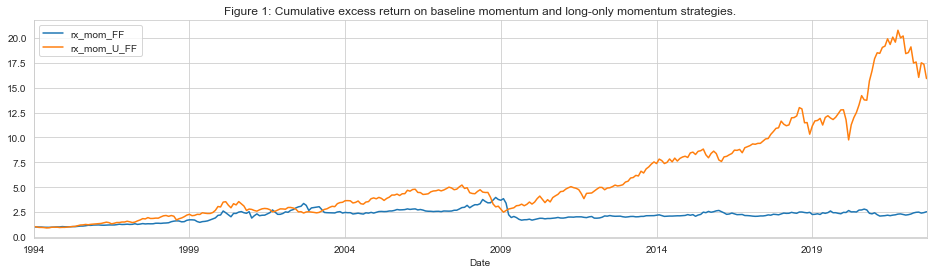

In [39]:
sns.set_style("whitegrid")
(momentum_size_data.loc['1994':'2022', 'rx_mom_FF'] + 1).cumprod().plot(figsize=(16,4))
(momentum_size_data.loc['1994':'2022', 'rx_mom_U_FF'] + 1).cumprod().plot(figsize=(16,4))
plt.title('Figure 1: Cumulative excess return on baseline momentum and long-only momentum strategies.')
plt.legend();

#### 3. Is momentum just data mining, or is it a robust strategy?

#### a) Compare all three constructions by filling out the stats in the table for 1994-2022.


In [41]:
# Long top 1 decile and short bottom 1 decile
momentum_size_data['rx_mom_D1'] = momentum_size_data['Hi PRIOR'] - momentum_size_data['Lo PRIOR']
table3 = pd.DataFrame(columns=['mean ', 'vol ', 'sharpe_ratio ', 'skew ', 'corr_to_mkt ', 'corr_to_value', ])

df = momentum_size_data.join(momentum_size_data, rsuffix='momentum_')
# long top 3 deciles and short bottom 3 deciles
df['rx_mom_D3'] = (1/3 * (df['PRIOR 8'] + df['PRIOR 9'] + df['Hi PRIOR']) -\
                1/3 * (df['Lo PRIOR'] + df['PRIOR 2'] + df['PRIOR 3']))

# long top 5 deciles and short bottom 5 deciles
df['rx_mom_D5'] = (1/5 * (df['PRIOR 6'] + df['PRIOR 7'] + df['PRIOR 8'] + df['PRIOR 9'] + df['Hi PRIOR']) -\
                1/5 * (df['Lo PRIOR'] + df['PRIOR 2'] + df['PRIOR 3'] + df['PRIOR 4'] + df['PRIOR 5']))
table3.loc['rx_mom_D1', :] = table_row(df['1994':], portfolio='rx_mom_D1')
table3.loc['rx_mom_D3', :] = table_row(df['1994':], portfolio='rx_mom_D3')
table3.loc['rx_mom_D5', :] = table_row(df['1994':], portfolio='rx_mom_D5')

table3

,mean,vol,sharpe_ratio,skew,corr_to_mkt,corr_to_value
rx_mom_D1,0.079409,0.297952,0.266515,-1.323613,-0.335574,-0.236392
rx_mom_D3,0.034203,0.192568,0.177615,-1.35538,-0.365386,-0.229882
rx_mom_D5,0.018031,0.134026,0.134536,-1.435409,-0.357936,-0.227501


#### 3.b Do the tradeoffs between 1-decile, 3-decile, and 5-decile constructions line up with the theoretical tradeoffs we discussed in the lecture?

During lecture, we discussed how the more extreme the cutoff for the 'winners', the higher we expect the means to be, at the cost of higher volatility. This is consistent with what we see in the above table.

#### 3.c Should AQR consider a 1-decile or 5-decile construction?

If they can accept the higher volatility, they should use a 1-decile construction. They will have more assets in the 5-decile construction, with correspondingly higher trading costs, but their vol is lower. I would argue for the 1-decile over the 5-decile if they had to pick, given how high the Sharpe ratio is for 1-decile vs. the Sharpe for 5-decile.

#### 3.d Does the D3 momentum have similar stats to French-Fama?

In [42]:
table2

,mean,vol,sharpe_ratio,skew,corr_to_mkt,corr_to_value
long_short,0.047329,0.168603,0.280711,-1.433724,-0.306118,-0.238548
long_only,0.112783,0.178903,0.630411,-0.482872,0.903499,-0.154667


It appears that French-Fama has slightly higher means and slightly lower vol, leading to a better Sharpe (0.28 vs. 0.18). They are both skewed roughly the same, with correlations to the market and value factors that are also very close. Overall, yes, the stats are similar, with the possible implication that segmentation by size does have better performance.

#### 4. Does implementing momentum require trading lots of small stocks- thus causing even larger trading costs?
Construct a small stock and large stock momentum portfolio.

In [44]:
# Construct the small stock momentum portfolio (small up - small down)
df['rx_mom_S'] = df['SMALL HiPRIOR'] - df['SMALL LoPRIOR']

# Construct the large stock momentum portfolio (large up - small down)
df['rx_mom_B'] = df['BIG HiPRIOR'] - df['BIG LoPRIOR']

# Create Table 4
table4 = pd.DataFrame(columns=['mean ', 'vol ', 'sharpe_ratio ', 'skew ', 'corr_to_mkt ','corr_to_v'])
table4.loc['All Stocks', :] = table_row(df['1994':], portfolio='rx_mom_FF')
table4.loc['Small stocks', :] = table_row(df['1994':], portfolio='rx_mom_S')
table4.loc['Large Stocks', :] = table_row(df['1994':], portfolio='rx_mom_B')
table4

,mean,vol,sharpe_ratio,skew,corr_to_mkt,corr_to_v
All Stocks,0.047329,0.168603,0.280711,-1.433724,-0.306118,-0.238548
Small stocks,0.062737,0.171615,0.365571,-1.750109,-0.306908,-0.164672
Large Stocks,0.03192,0.181863,0.175517,-0.857615,-0.277984,-0.286919


#### 4.b Is the attractiveness of the momentum strategy mostly driven by small stocks? That is, does a momentum strategy in large stocks still deliver excess returns at comparable risk?

Based on the table above, small stocks do deliver higher returns, but only 6% compared to large stocks' 3%, and their volatility is about the same. It seems like a portfolio of large stocks may be worth the lower returns in exchange for lower trading costs/frequency.

#### 5. What is your assessment of the AQR retail product? Is it capturing the most important features of French Fama? Would you suggest any modifications?

I would say that AQR's product is a good one. It doesn't really match what we typically refer to as momentum, as it goes long only, and is therefore mostly getting its returns from market premium. However, it is more practical to implement than French Fama's momentum strategy.